# Imported Libraries

In [1]:

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, BatchNormalization, LSTM, Input, Reshape 
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import random
import cv2
import os



# Image Dataset Import

In [2]:
labels = ['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
img_size = 224
def get_data(data_dir):
    data = [] 
    
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                crop_image= img_arr[0:1728,430:2190]
                resized_arr = cv2.resize(crop_image, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
#function call to get_data function that takes file path of the dataset.
data= get_data('dataset/dataset_all_equal_size_image/')

<ipython-input-2-b08f5e223f84>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


In [4]:
data.shape

(600, 2)

In [5]:
type(data)

numpy.ndarray

# Dividing Data Ndarray into Normal, Cataract, Glaucoma and Retina diseases. 

In [6]:
normal= data[0:300]
normal.shape

(300, 2)

In [7]:
cataract=data[300:400]
cataract.shape

(100, 2)

In [8]:
glaucoma= data[400:500]
glaucoma.shape

(100, 2)

In [9]:
retina_disease= data[500:600]
retina_disease.shape

(100, 2)

In [10]:
random.seed(15)
np.random.shuffle(normal)
np.random.shuffle(cataract)   
np.random.shuffle(glaucoma)
np.random.shuffle(retina_disease)

# Performing Normalization and Resize operation 

In [11]:
def normalize(x_train,x_val,x_test): 
    
    x_train = np.array(x_train) / 255
    x_train.reshape(-1, img_size, img_size, 1)
    
    x_test= np.array(x_test) / 255
    x_test.reshape(-1, img_size, img_size, 1)
    
    
    x_val= np.array(x_val) / 255
    x_val.reshape(-1, img_size, img_size, 1)
    
    
        
    return (x_train,x_val,x_test) 


# Separating the Images and Labels into Respective Variables

In [12]:
def image_label_split(train,validation,test):
    
    x_train = []
    y_train = []
    x_val = []
    y_val = []
    x_test = []
    y_test = []

    for feature, label in train:
      x_train.append(feature)
      y_train.append(label)

    for feature, label in validation:
      x_val.append(feature)
      y_val.append(label)


    for feature, label in test:
      x_test.append(feature)
      y_test.append(label)

        
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test= np.array(y_test)
    
    return (x_train,y_train,x_val,y_val,x_test,y_test)


# InceptionResNetV2-LSTM MODEL

In [13]:
def model_build_compile(k):     
    baseModel = InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    for layer in baseModel.layers:
            layer.trainable = False

    x = baseModel.output

        # LSTM layer
    x = Reshape((25,1536))(x)
    x = ((LSTM(512, activation="relu", return_sequences=True, trainable=False)))(x)
    x = BatchNormalization()(x)
    #     

        # FC layer
    x = Flatten(name="flatten")(x)

        # fc1 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)
    #    

        # fc2 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)
    #     

        # Output layer
    output = Dense(units=4, activation='softmax')(x)

    model = Model(inputs=baseModel.input, outputs=output)
    opt = RMSprop(learning_rate=0.01, clipvalue=100)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    k=k+1
    print("model building and compiling for fold",k)
    return model

# Model prediction for Test Images and Computation of Sensitivity and Specificity

In [14]:
def test_pred(x_val,y_val,k):
    predictions = model.predict(x_val)
    predictions = np.argmax(predictions, axis = -1)
    
    print('----------------Test accuracy for',k+1,'fold----------------')
    #Confusion matrix, Accuracy, sensitivity and specificity
    cm1 = confusion_matrix(y_val,predictions)
    print('Confusion Matrix : \n', cm1)

    #####from confusion matrix calculate accuracy
    
    sensitivity_1_normal = (cm1[0,0])/(cm1[0,0]+cm1[0,1]+cm1[0,2]+cm1[0,3])
    #print('Sensitivity_1_normal          : ', sensitivity_1_normal )

    sensitivity_2_cataract = (cm1[1,1])/(cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[1,3])
    #print('Sensitivity_2_cataract        : ', sensitivity_2_cataract )


    sensitivity_3_glaucoma = (cm1[2,2])/(cm1[2,0]+cm1[2,1]+cm1[2,2]+cm1[2,3])
    #print('Sensitivity_3_glaucoma        : ', sensitivity_3_glaucoma )

    sensitivity_4_retina_disease = (cm1[3,3])/(cm1[3,0]+cm1[3,1]+cm1[3,2]+cm1[3,3])
    #print('Sensitivity_4_retina_disease  : ', sensitivity_4_retina_disease )
    
    specificity_1_normal = (cm1[1,1]+cm1[1,2]+cm1[1,3]+cm1[2,1]+cm1[2,2]+cm1[2,3]+cm1[3,1]+cm1[3,2]+cm1[3,3])/(cm1[1,0]+cm1[2,0]+cm1[3,0]+cm1[1,1]+cm1[1,2]+cm1[1,3]+cm1[2,1]+cm1[2,2]+cm1[2,3]+cm1[3,1]+cm1[3,2]+cm1[3,3])
    #print('Specificity : ', specificity_1_normal)

    specificity_2_cataract = (cm1[0,0]+cm1[0,2]+cm1[0,3]+cm1[2,0]+cm1[2,2]+cm1[2,3]+cm1[3,0]+cm1[3,2]+cm1[3,3])/(cm1[0,1]+cm1[2,1]+cm1[3,1]+cm1[0,0]+cm1[0,2]+cm1[0,3]+cm1[2,0]+cm1[2,2]+cm1[2,3]+cm1[3,0]+cm1[3,2]+cm1[3,3])
    #print('Specificity : ', specificity_2_cataract)

    specificity_3_glaucoma = (cm1[0,0]+cm1[0,1]+cm1[0,3]+cm1[1,0]+cm1[1,1]+cm1[1,3]+cm1[3,0]+cm1[3,1]+cm1[3,3])/(cm1[0,2]+cm1[1,2]+cm1[3,2]+cm1[0,0]+cm1[0,1]+cm1[0,3]+cm1[1,0]+cm1[1,1]+cm1[1,3]+cm1[3,0]+cm1[3,1]+cm1[3,3])
    #print('Specificity : ', specificity_3_glaucoma)

    specificity_4_retina_disease= (cm1[0,0]+cm1[0,1]+cm1[0,2]+cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[2,0]+cm1[2,1]+cm1[2,2])/(cm1[0,3]+cm1[1,3]+cm1[2,3]+cm1[0,0]+cm1[0,1]+cm1[0,2]+cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[2,0]+cm1[2,1]+cm1[2,2])
    #print('Specificity : ', specificity_4_retina_disease)

    Sensitivity= (sensitivity_1_normal + sensitivity_2_cataract + sensitivity_3_glaucoma + sensitivity_4_retina_disease)/4
    #print(Sensitivity)
    
    Specificity= (specificity_1_normal + specificity_2_cataract + specificity_3_glaucoma + specificity_4_retina_disease)/4
    #print(Specificity)
    
    total1=sum(sum(cm1))
    test_accuracy=(cm1[0,0]+cm1[1,1]+cm1[2,2]+cm1[3,3])/total1
    
    print ('Accuracy    : ', test_accuracy)
    print ('Specificity : ', Specificity)
    print ('Sensitivity : ', Sensitivity)
    print('-----------------------------End of',k+1,'Fold--------------------------')
    return test_accuracy,Specificity,Sensitivity,cm1

In [15]:
CM= []
test_accuracy=[]
test_sensitivity=[]
test_specificity=[]
train_acc = []
val_acc = []
train_loss = []
val_loss = []


# InceptionResNetV2-LSTM 5 Fold Cross Validation

In [16]:
for k in range (5):  # for loop to run 5 folds 
    n_normal=30      # specifying the number of images for normal class in test phase,calulated as per 10% of total normal class images 300.
    n_rest=10        # specifying the number of images for disease classes in test phase,calulated as per 10% of total normal class images 100.
    
    # Adding the images in normal validation set by using k*n_normal to (k+1)*n_normal as index values for normal dataset divided in cell 6.
    test_normal= normal[k*n_normal:(k+1)*n_normal]                              
    print('------------------------Start of',k+1,'Fold------------------------')
    print('test images for normal class from',k*n_normal,(k+1)*n_normal)
    
    # Adding the images in cataract validation set by using k*n_rest to (k+1)*n_rest as index values for cataract dataset divided in cell 7.
    test_cataract= cataract[k*n_rest:(k+1)*n_rest]
    print('test images for cataract class from',k*n_rest,(k+1)*n_rest)
    
    # Adding the images in gluacoma validation set by using k*n_rest to (k+1)*n_rest as index values for gluacoma dataset divided in cell 8.
    test_glaucoma= glaucoma[k*n_rest:(k+1)*n_rest]
    print('test images for glaucoma class from',k*n_rest,(k+1)*n_rest)
    
    # Adding the images in retina disease validation set by using k*n_rest to (k+1)*n_rest as index values for retina disease dataset divided in cell 9.
    test_retina= retina_disease[k*n_rest:(k+1)*n_rest]
    print('test images for retina disease class from',k*n_rest,(k+1)*n_rest)
    
    # Now for train and validation set of Normal images first adding 0 to k*n_normal images and then adding all the images from (k+1)*n_normal till last image. 
    
    train_validation_normal= normal[:k*n_normal] 
    train_validation_normal= np.append(train_validation_normal,normal[(k+1)*n_normal:],axis=0)
    print('train_validation images for normal class from 0 to',k*n_normal,'and',(k+1)*n_normal,'to 300')

    # Now for train and validation set of cataract images first adding 0 to k*n_rest images and then adding all the images from (k+1)*n_rest till last image. 

    train_validation_cataract= cataract[:k*n_rest] 
    train_validation_cataract= np.append(train_validation_cataract,cataract[(k+1)*n_rest:],axis=0)
    print('train_validation images for cataract class from 0 to',k*n_rest,'and',(k+1)*n_rest,'to 100')
    
    # Now for train and validation set of glaucoma images first adding 0 to k*n_rest images and then adding all the images from (k+1)*n_rest till last image. 
    train_validation_glaucoma= glaucoma[:k*n_rest] 
    train_validation_glaucoma= np.append(train_validation_glaucoma,glaucoma[(k+1)*n_rest:],axis=0)
    print('train_validation  images for glaucoma class from 0',k*n_rest,'and',(k+1)*n_rest,'to 100')
    
    # Now for train and validation set of retina disease images first adding 0 to k*n_rest images and then adding all the images from (k+1)*n_rest till last image. 
    train_validation_retina= retina_disease[:k*n_rest] 
    train_validation_retina= np.append(train_validation_retina,retina_disease[(k+1)*n_rest:],axis=0)
    print('train_validation images for retina disease class from 0 to',k*n_rest,'and',(k+1)*n_rest,'to 100')
    
    
    # Splitting the train validation datasets in 80:20 ratio which would eventually give us 70% images in train and 20% images in validation and 10% in test.
    normal_train, normal_validation                 = train_test_split(train_validation_normal, test_size=0.20, random_state=14,shuffle=True)
    cataract_train, cataract_validation             = train_test_split(train_validation_cataract, test_size=0.20, random_state=14,shuffle=True)
    glaucoma_train, glaucoma_validation             = train_test_split(train_validation_glaucoma, test_size=0.20, random_state=14,shuffle=True)
    retina_disease_train, retina_disease_validation = train_test_split(train_validation_retina, test_size=0.20, random_state=14,shuffle=True)

    # Appending all train set images for all classes
    train= np.append(normal_train,cataract_train,axis=0)
    train= np.append(train,glaucoma_train,axis=0)
    train= np.append(train,retina_disease_train,axis=0)

    # Appending all validation set images for all classes
    validation= np.append(normal_validation,cataract_validation,axis=0)
    validation= np.append(validation,glaucoma_validation,axis=0)
    validation= np.append(validation,retina_disease_validation,axis=0)
    
    # Appending all test set images for all classes
    test= np.append(test_normal,test_cataract,axis=0)
    test= np.append(test,test_glaucoma,axis=0)
    test= np.append(test,test_retina,axis=0)    
    
    # Shuffling the train validation and test set as they are added sequentially. 
    random.seed(6)
    np.random.shuffle(train)
    np.random.shuffle(validation)   
    np.random.shuffle(test)
 
    # Passing the train validation test as argument for image_label_split function that return features and labels separated.
    x_train,y_train,x_val,y_val,x_test,y_test = image_label_split(train,validation,test)
    
    # Passing the x_Train x_val and x_test as a argument for normalize function that returns the normalized and reshaped sets.
    x_train,x_val,x_test = normalize(x_train,x_val,x_test)
    
   # model building and model compile is done using a model_build_compile(). 
    
    model = model_build_compile(k)
    history = model.fit(x_train,y_train,epochs =50, validation_data = (x_val,y_val))
    

    train_acc = np.append(train_acc,history.history['accuracy'])
    val_acc = np.append(val_acc,history.history['val_accuracy'])
    
    train_loss = np.append(train_loss,history.history['loss'])
    val_loss = np.append(val_loss,history.history['val_loss'])
                        
    x,y,z,c = test_pred(x_test,y_test,k)
    

    CM.append([c])
    test_accuracy.append(x)
    test_specificity.append(y)
    test_sensitivity.append(z)
 

------------------------Start of 1 Fold------------------------
test images for normal class from 0 30
test images for cataract class from 0 10
test images for glaucoma class from 0 10
test images for retina disease class from 0 10
train_validation images for normal class from 0 to 0 and 30 to 300
train_validation images for cataract class from 0 to 0 and 10 to 100
train_validation  images for glaucoma class from 0 0 and 10 to 100
train_validation images for retina disease class from 0 to 0 and 10 to 100
model building and compiling for fold 1
Epoch 1/50
14/14 [==============================] - 58s 3s/step - loss: 17.2841 - accuracy: 0.4190 - val_loss: 153.5402 - val_accuracy: 0.2685
Epoch 2/50
14/14 [==============================] - 51s 4s/step - loss: 9.7481 - accuracy: 0.4722 - val_loss: 55.7080 - val_accuracy: 0.5833
Epoch 3/50
14/14 [==============================] - 54s 4s/step - loss: 6.4178 - accuracy: 0.5463 - val_loss: 19.1684 - val_accuracy: 0.6111
Epoch 4/50
14/14 [=======

model building and compiling for fold 2
Epoch 1/50
14/14 [==============================] - 73s 5s/step - loss: 17.2635 - accuracy: 0.3889 - val_loss: 171.5703 - val_accuracy: 0.2778
Epoch 2/50
14/14 [==============================] - 60s 4s/step - loss: 8.0821 - accuracy: 0.5046 - val_loss: 29.0900 - val_accuracy: 0.3519
Epoch 3/50
14/14 [==============================] - 61s 4s/step - loss: 7.6368 - accuracy: 0.4722 - val_loss: 13.2008 - val_accuracy: 0.5833
Epoch 4/50
14/14 [==============================] - 61s 4s/step - loss: 5.7092 - accuracy: 0.5579 - val_loss: 20.1447 - val_accuracy: 0.3426
Epoch 5/50
14/14 [==============================] - 61s 4s/step - loss: 4.6409 - accuracy: 0.5833 - val_loss: 23.1926 - val_accuracy: 0.4259
Epoch 6/50
14/14 [==============================] - 60s 4s/step - loss: 2.1570 - accuracy: 0.6065 - val_loss: 6.6577 - val_accuracy: 0.5185
Epoch 7/50
14/14 [==============================] - 61s 4s/step - loss: 2.8875 - accuracy: 0.6597 - val_loss: 3.1

Epoch 3/50
14/14 [==============================] - 63s 5s/step - loss: 8.0075 - accuracy: 0.5162 - val_loss: 19.2802 - val_accuracy: 0.4352
Epoch 4/50
14/14 [==============================] - 66s 5s/step - loss: 3.1340 - accuracy: 0.6435 - val_loss: 5.3265 - val_accuracy: 0.5833
Epoch 5/50
14/14 [==============================] - 69s 5s/step - loss: 4.8871 - accuracy: 0.6111 - val_loss: 11.5907 - val_accuracy: 0.3889
Epoch 6/50
14/14 [==============================] - 67s 5s/step - loss: 2.5160 - accuracy: 0.6829 - val_loss: 5.8496 - val_accuracy: 0.4352
Epoch 7/50
14/14 [==============================] - 65s 5s/step - loss: 1.2175 - accuracy: 0.7361 - val_loss: 4.3941 - val_accuracy: 0.4167
Epoch 8/50
14/14 [==============================] - 62s 4s/step - loss: 1.4838 - accuracy: 0.7593 - val_loss: 8.0205 - val_accuracy: 0.3796
Epoch 9/50
14/14 [==============================] - 65s 5s/step - loss: 1.3021 - accuracy: 0.7801 - val_loss: 8.0694 - val_accuracy: 0.3333
Epoch 10/50
14/14 

Epoch 5/50
14/14 [==============================] - 65s 5s/step - loss: 6.3400 - accuracy: 0.5903 - val_loss: 22.1179 - val_accuracy: 0.2870
Epoch 6/50
14/14 [==============================] - 65s 5s/step - loss: 2.5884 - accuracy: 0.6458 - val_loss: 5.7328 - val_accuracy: 0.4722
Epoch 7/50
14/14 [==============================] - 65s 5s/step - loss: 1.1794 - accuracy: 0.7708 - val_loss: 8.2184 - val_accuracy: 0.4167
Epoch 8/50
14/14 [==============================] - 64s 5s/step - loss: 1.9006 - accuracy: 0.7037 - val_loss: 7.2428 - val_accuracy: 0.4630
Epoch 9/50
14/14 [==============================] - 65s 5s/step - loss: 1.7541 - accuracy: 0.7616 - val_loss: 7.9216 - val_accuracy: 0.3889
Epoch 10/50
14/14 [==============================] - 72s 5s/step - loss: 1.4971 - accuracy: 0.8264 - val_loss: 4.8575 - val_accuracy: 0.5000
Epoch 11/50
14/14 [==============================] - 73s 5s/step - loss: 1.3741 - accuracy: 0.8171 - val_loss: 6.2237 - val_accuracy: 0.5278
Epoch 12/50
14/14

Epoch 7/50
14/14 [==============================] - 74s 5s/step - loss: 2.2885 - accuracy: 0.7106 - val_loss: 4.0748 - val_accuracy: 0.4167
Epoch 8/50
14/14 [==============================] - 71s 5s/step - loss: 1.0823 - accuracy: 0.7685 - val_loss: 10.0831 - val_accuracy: 0.2963
Epoch 9/50
14/14 [==============================] - 75s 5s/step - loss: 0.9378 - accuracy: 0.8194 - val_loss: 11.5755 - val_accuracy: 0.3519
Epoch 10/50
14/14 [==============================] - 79s 6s/step - loss: 1.0131 - accuracy: 0.7986 - val_loss: 4.7080 - val_accuracy: 0.3148
Epoch 11/50
14/14 [==============================] - 77s 6s/step - loss: 1.1128 - accuracy: 0.8495 - val_loss: 7.1734 - val_accuracy: 0.3611
Epoch 12/50
14/14 [==============================] - 77s 6s/step - loss: 0.6837 - accuracy: 0.8727 - val_loss: 11.3418 - val_accuracy: 0.2870
Epoch 13/50
14/14 [==============================] - 74s 5s/step - loss: 0.6888 - accuracy: 0.8657 - val_loss: 13.1919 - val_accuracy: 0.2870
Epoch 14/50


# Test Evaluation Results

In [17]:
test_accuracy

[0.5666666666666667, 0.55, 0.5833333333333334, 0.55, 0.5333333333333333]

In [18]:
mean_test_accuracy=np.mean(test_accuracy)
mean_test_accuracy

0.5566666666666666

In [19]:
test_sensitivity

[0.5499999999999999, 0.525, 0.5083333333333333, 0.4083333333333334, 0.4]

In [20]:
mean_test_sensitivity= np.mean(test_sensitivity)
mean_test_sensitivity

0.47833333333333333

In [21]:
test_specificity

[0.8035666088297667,
 0.7957754454847479,
 0.790736836692719,
 0.7624597799547089,
 0.7516287716287716]

In [22]:
mean_test_specificity= np.mean(test_specificity)
mean_test_specificity

0.7808334885181429

# Training and Validation Evaluation Results

In [23]:
train_acc

array([0.41898149, 0.47222221, 0.5462963 , 0.59953701, 0.63194442,
       0.6087963 , 0.70833331, 0.7962963 , 0.7638889 , 0.8125    ,
       0.81712961, 0.9074074 , 0.88194442, 0.88194442, 0.89351851,
       0.91898149, 0.94675928, 0.9050926 , 0.91898149, 0.93055558,
       0.94907409, 0.93518519, 0.93287039, 0.94212961, 0.94444442,
       0.93981481, 0.94907409, 0.9537037 , 0.98842591, 0.96296299,
       0.97453701, 0.94675928, 0.97222221, 0.9675926 , 0.95601851,
       0.97685188, 0.95601851, 0.9675926 , 0.9513889 , 0.97453701,
       0.9537037 , 0.97222221, 0.99537039, 0.96296299, 0.9513889 ,
       0.9861111 , 0.9861111 , 0.9699074 , 0.97685188, 0.9699074 ,
       0.3888889 , 0.50462961, 0.47222221, 0.55787039, 0.58333331,
       0.60648149, 0.65972221, 0.76851851, 0.75925928, 0.80324072,
       0.81712961, 0.83796299, 0.9212963 , 0.80787039, 0.9236111 ,
       0.90972221, 0.90277779, 0.90972221, 0.91435188, 0.94907409,
       0.94212961, 0.93055558, 0.94212961, 0.93518519, 0.96064

In [24]:
mean_train_accuracy=np.mean(train_acc)
mean_train_accuracy

0.8844629625082016

In [25]:
val_acc

array([0.26851851, 0.58333331, 0.6111111 , 0.51851851, 0.49074075,
       0.57407409, 0.3425926 , 0.26851851, 0.27777779, 0.47222221,
       0.19444445, 0.48148149, 0.25      , 0.3425926 , 0.28703704,
       0.41666666, 0.3888889 , 0.3888889 , 0.51851851, 0.4074074 ,
       0.44444445, 0.27777779, 0.3611111 , 0.57407409, 0.42592594,
       0.53703701, 0.55555558, 0.56481481, 0.58333331, 0.48148149,
       0.5462963 , 0.62962961, 0.53703701, 0.48148149, 0.52777779,
       0.67592591, 0.6574074 , 0.71296299, 0.71296299, 0.62037039,
       0.62962961, 0.6388889 , 0.62962961, 0.62037039, 0.41666666,
       0.50925928, 0.62037039, 0.49074075, 0.5925926 , 0.60185188,
       0.27777779, 0.35185185, 0.58333331, 0.3425926 , 0.42592594,
       0.51851851, 0.5       , 0.48148149, 0.37962964, 0.2962963 ,
       0.48148149, 0.37037036, 0.47222221, 0.52777779, 0.53703701,
       0.49074075, 0.47222221, 0.47222221, 0.46296296, 0.55555558,
       0.3425926 , 0.55555558, 0.58333331, 0.4074074 , 0.5    

In [26]:
mean_val_accuracy=np.mean(val_acc)
mean_val_accuracy

0.5006296305656434

In [27]:
train_loss

array([1.72841301e+01, 9.74805164e+00, 6.41780710e+00, 3.93864870e+00,
       3.14864564e+00, 4.25907993e+00, 1.60331726e+00, 1.31203234e+00,
       1.33422756e+00, 1.09247172e+00, 2.14421582e+00, 4.93645161e-01,
       8.81963491e-01, 7.93705463e-01, 7.75893748e-01, 6.17669344e-01,
       3.93884420e-01, 6.56697512e-01, 5.88859618e-01, 5.19827962e-01,
       3.50265235e-01, 5.87748945e-01, 6.05326176e-01, 2.90918261e-01,
       2.90612429e-01, 5.94127536e-01, 2.34718740e-01, 5.23282766e-01,
       6.63762018e-02, 2.28535295e-01, 9.19221416e-02, 4.91625637e-01,
       1.38091639e-01, 2.40258530e-01, 3.48894536e-01, 3.13991487e-01,
       3.45467627e-01, 4.39981073e-01, 3.80849808e-01, 1.88644975e-01,
       3.14365119e-01, 1.42126426e-01, 4.48983349e-03, 2.27064118e-01,
       4.27701503e-01, 3.09979171e-02, 8.45943317e-02, 1.74587190e-01,
       1.14005566e-01, 1.61222577e-01, 1.72635193e+01, 8.08212757e+00,
       7.63679457e+00, 5.70920897e+00, 4.64085054e+00, 2.15698242e+00,
      

In [28]:
mean_train_loss=np.mean(train_loss)
mean_train_loss

1.2763155761882663

In [29]:
val_loss

array([153.54016113,  55.70801544,  19.16837502,   6.39042139,
         5.82477427,   7.98298073,  10.14249802,   4.65828228,
        10.66814709,  12.60039902,  25.20410156,   9.21026993,
        23.38103104,  12.59810829,  20.27552223,   7.16247845,
        10.60472775,   7.29560328,   9.47160244,   8.71938705,
         8.28960133,  19.21827888,  12.86996841,   8.55958748,
        18.33307838,   7.52307796,   6.35692215,   6.89080572,
         5.79446793,   8.89416885,   9.24718761,  11.95727444,
        17.58582115,  38.73047256,  21.6259613 ,  11.14853096,
        10.00309658,   9.72321892,   7.13947105,  14.32043934,
        13.43727589,   8.56797123,  11.17147827,   9.12106514,
        16.26109505,  11.21669388,   9.07446957,  16.17450142,
        18.36318588,  10.72614384, 171.57029724,  29.09004402,
        13.20075607,  20.14474297,  23.19255066,   6.65774965,
         3.10536385,   5.83740187,   4.8640666 ,  17.53942108,
         4.4922967 ,   6.12019539,   5.0065093 ,   5.50

In [30]:
mean_val_loss=np.mean(val_loss)
mean_val_loss

14.292034516334533

# Plot to Visualize the Number of Images in Each Label of Trainig Dataset

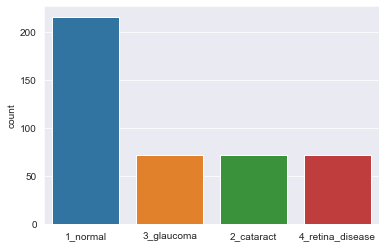

In [31]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("1_normal")
        
    elif (i[1] == 1):
        l.append("2_cataract")
        
    elif (i[1] == 2):
        l.append("3_glaucoma")
        
    else :
        l.append("4_retina_disease")
            
    
sns.set_style('darkgrid')
sns.countplot(l)

# Plot to Visualize the Number of Images in Each Label of Test Dataset.

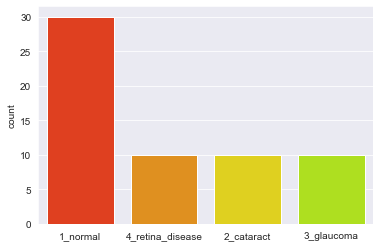

In [32]:
l = []
for i in test:
    if(i[1] == 0):
        l.append("1_normal")
        
    elif (i[1] == 1):
        l.append("2_cataract")
        
    elif (i[1] == 2):
        l.append("3_glaucoma")
        
    else :
        l.append("4_retina_disease")
            
    
sns.set_style('darkgrid')
sns.countplot(l,palette='prism')

# Plot to Visualize the Number of Images in Each Label of Validation Dataset.

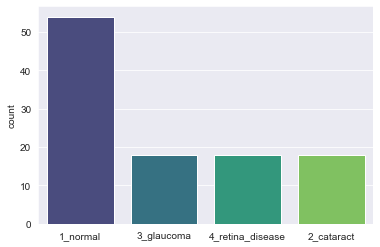

In [33]:
l = []
for i in validation:
    if(i[1] == 0):
        l.append("1_normal")
        
    elif (i[1] == 1):
        l.append("2_cataract")
        
    elif (i[1] == 2):
        l.append("3_glaucoma")
        
    else :
        l.append("4_retina_disease")
            
    
sns.set_style('darkgrid')
sns.countplot(l,palette='viridis')

# Training,Validation Accuracy and Loss Plot for 50 Epochs

In [34]:
def plot_print(i,j):
    epochs_range = range(50)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, train_acc[i:j], label='Training Accuracy')
    plt.plot(epochs_range, val_acc[i:j], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, train_loss[i:j], label='Training Loss')
    plt.plot(epochs_range, val_loss[i:j], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    return plt.show()

Plot for  1 cross validation accuracy and loss for Training and Validation phase


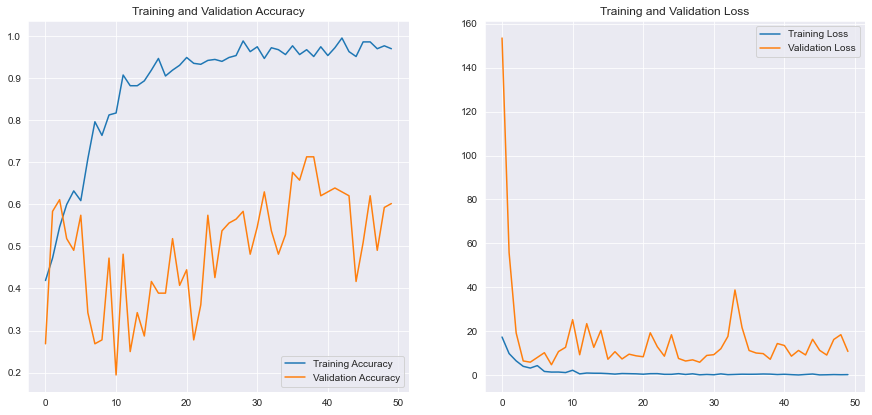

Plot for  2 cross validation accuracy and loss for Training and Validation phase


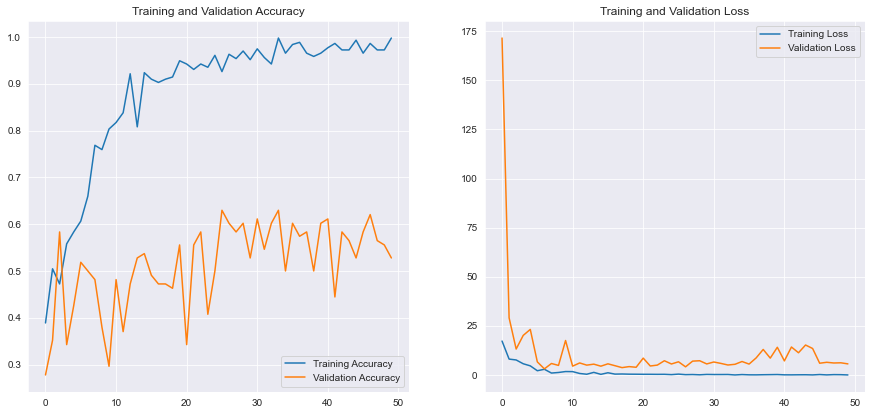

Plot for  3 cross validation accuracy and loss for Training and Validation phase


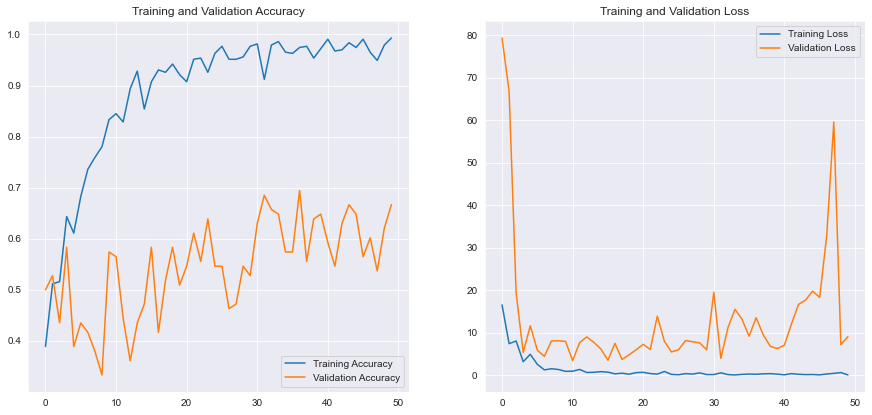

Plot for  4 cross validation accuracy and loss for Training and Validation phase


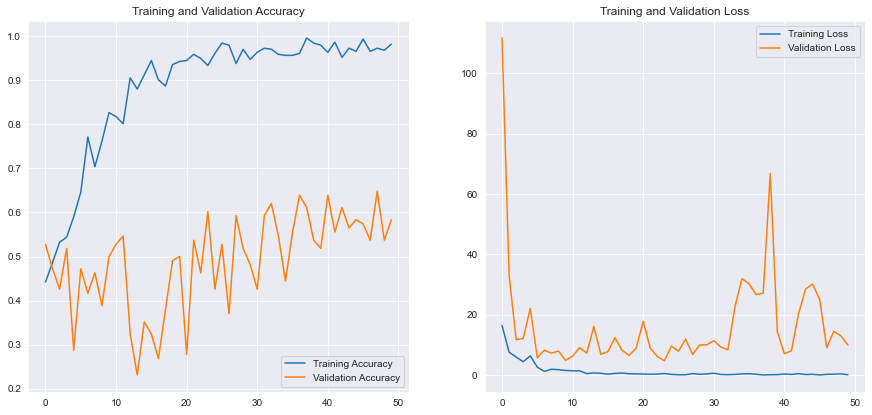

Plot for  5 cross validation accuracy and loss for Training and Validation phase


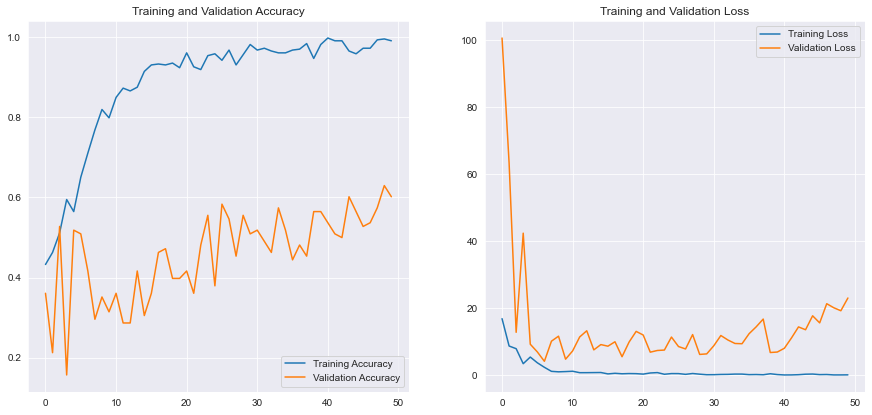

In [35]:
k=1
j=0
for i in range(0,250,50):
    j +=50
    print('Plot for ',k,'cross validation accuracy and loss for Training and Validation phase')
    k +=1
    plot_print(i,j)


# Visualizing Confusion Matrix for Each Fold

In [36]:
CM= np.array(CM)
CM.resize(5,4,4)

In [37]:
def confusionmatrix_vis(i):

        yticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
        xticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
        plt.figure(figsize=(8, 8))
        hm =sns.heatmap(CM[i], annot=True,annot_kws={"size": 20}, cbar=False,cmap="YlGnBu",yticklabels=yticklabels,xticklabels=xticklabels)

        hm.set_xticklabels(hm.get_xticklabels(), rotation=0, fontsize = 12, ) 
        hm.set_yticklabels(hm.get_yticklabels(), rotation=0, fontsize = 12) 

        plt.ylabel("Actual", fontsize = 18)
        plt.xlabel("Predicted",fontsize = 18)
      
        return plt.show()

Confusion Matrix for  1 Cross Validation Test phase


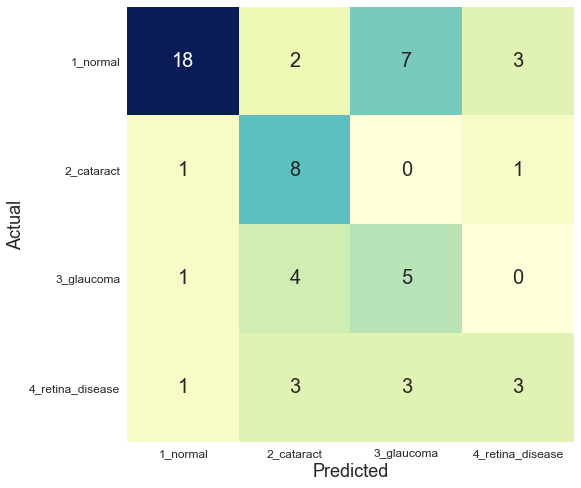

Confusion Matrix for  2 Cross Validation Test phase


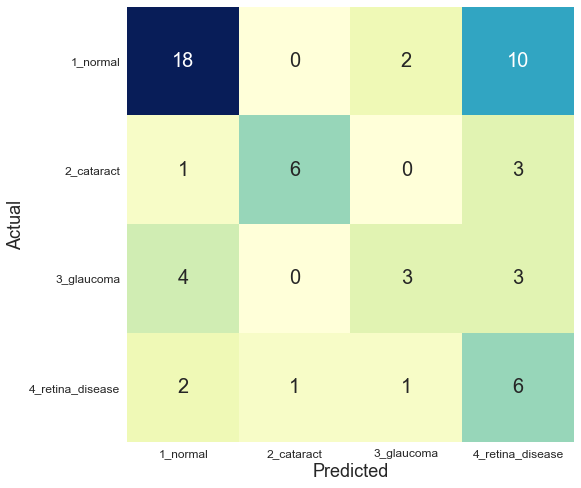

Confusion Matrix for  3 Cross Validation Test phase


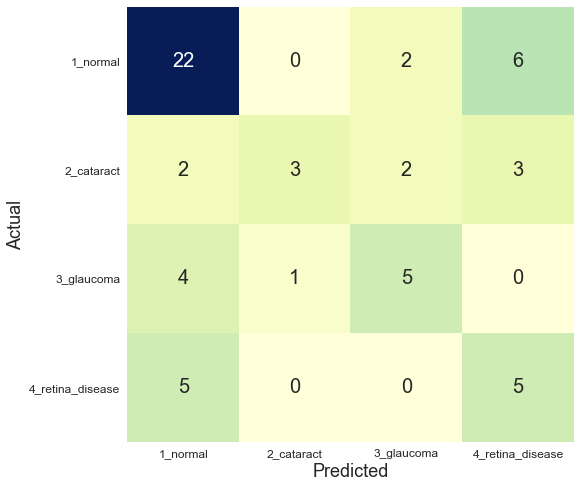

Confusion Matrix for  4 Cross Validation Test phase


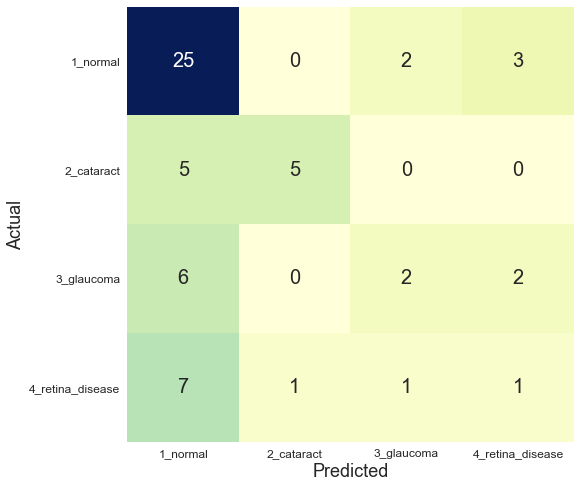

Confusion Matrix for  5 Cross Validation Test phase


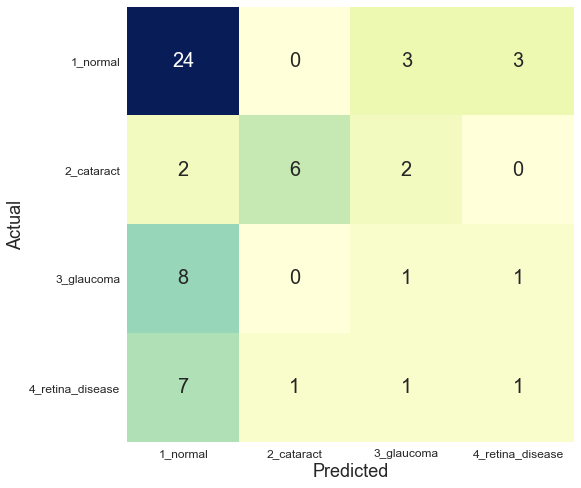

In [38]:
k=1
for i in range(5):    
    print('Confusion Matrix for ',k,'Cross Validation Test phase')
    k +=1
    confusionmatrix_vis(i)
    


# Visualizing Summarized Confusion Matrix of all 5 folds

In [39]:
CM_sum = CM[0]+CM[1]+CM[2]+CM[3]+CM[4]
CM_sum

array([[107,   2,  16,  25],
       [ 11,  28,   4,   7],
       [ 23,   5,  16,   6],
       [ 22,   6,   6,  16]], dtype=int64)

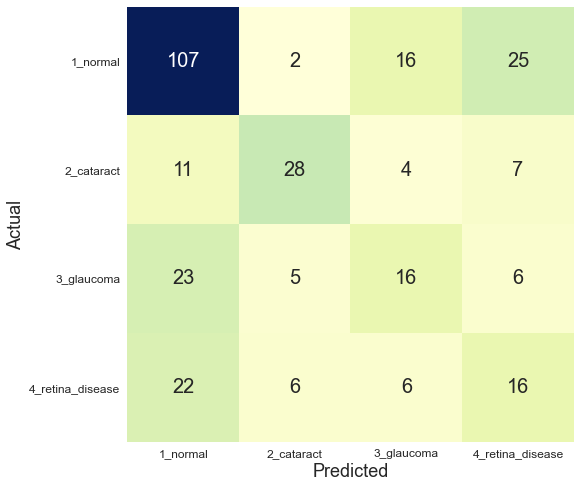

In [40]:
yticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
xticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
plt.figure(figsize=(8, 8))
hm =sns.heatmap(CM_sum, annot=True,annot_kws={"size": 20},fmt='g', cbar=False,cmap="YlGnBu",yticklabels=yticklabels,xticklabels=xticklabels)

hm.set_xticklabels(hm.get_xticklabels(), rotation=0, fontsize = 12, ) 
hm.set_yticklabels(hm.get_yticklabels(), rotation=0, fontsize = 12) 

plt.ylabel("Actual", fontsize = 18)
plt.xlabel("Predicted",fontsize = 18)
      
plt.show()

# Reconfirming the values of Accuracy,Sensitivity and Specificity

In [41]:
    sensitivity_1_normal = (CM_sum[0,0])/(CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,2]+CM_sum[0,3])
    #print('Sensitivity_1_normal          : ', sensitivity_1_normal )

    sensitivity_2_cataract = (CM_sum[1,1])/(CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[1,3])
    #print('Sensitivity_2_cataract        : ', sensitivity_2_cataract )


    sensitivity_3_glaucoma = (CM_sum[2,2])/(CM_sum[2,0]+CM_sum[2,1]+CM_sum[2,2]+CM_sum[2,3])
    #print('Sensitivity_3_glaucoma        : ', sensitivity_3_glaucoma )

    sensitivity_4_retina_disease = (CM_sum[3,3])/(CM_sum[3,0]+CM_sum[3,1]+CM_sum[3,2]+CM_sum[3,3])
    #print('Sensitivity_4_retina_disease  : ', sensitivity_4_retina_disease )
    
    specificity_1_normal = (CM_sum[1,1]+CM_sum[1,2]+CM_sum[1,3]+CM_sum[2,1]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,1]+CM_sum[3,2]+CM_sum[3,3])/(CM_sum[1,0]+CM_sum[2,0]+CM_sum[3,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[1,3]+CM_sum[2,1]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,1]+CM_sum[3,2]+CM_sum[3,3])
    #print('Specificity : ', specificity_1_normal)

    specificity_2_cataract = (CM_sum[0,0]+CM_sum[0,2]+CM_sum[0,3]+CM_sum[2,0]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,0]+CM_sum[3,2]+CM_sum[3,3])/(CM_sum[0,1]+CM_sum[2,1]+CM_sum[3,1]+CM_sum[0,0]+CM_sum[0,2]+CM_sum[0,3]+CM_sum[2,0]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,0]+CM_sum[3,2]+CM_sum[3,3])
    #print('Specificity : ', specificity_2_cataract)

    specificity_3_glaucoma = (CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,3]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,3]+CM_sum[3,0]+CM_sum[3,1]+CM_sum[3,3])/(CM_sum[0,2]+CM_sum[1,2]+CM_sum[3,2]+CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,3]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,3]+CM_sum[3,0]+CM_sum[3,1]+CM_sum[3,3])
    #print('Specificity : ', specificity_3_glaucoma)

    specificity_4_retina_disease= (CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,2]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[2,0]+CM_sum[2,1]+CM_sum[2,2])/(CM_sum[0,3]+CM_sum[1,3]+CM_sum[2,3]+CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,2]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[2,0]+CM_sum[2,1]+CM_sum[2,2])
    #print('Specificity : ', specificity_4_retina_disease)

    Sensitivity= (sensitivity_1_normal + sensitivity_2_cataract + sensitivity_3_glaucoma + sensitivity_4_retina_disease)/4
    #print(Sensitivity)
    
    Specificity= (specificity_1_normal + specificity_2_cataract + specificity_3_glaucoma + specificity_4_retina_disease)/4
    #print(Specificity)
    
    total1=sum(sum(CM_sum))
    test_accuracy=(CM_sum[0,0]+CM_sum[1,1]+CM_sum[2,2]+CM_sum[3,3])/total1
    
    print ('Accuracy    : ', test_accuracy)
    print ('Specificity : ', Specificity)
    print ('Sensitivity : ', Sensitivity)


Accuracy    :  0.5566666666666666
Specificity :  0.7709410517738597
Sensitivity :  0.4783333333333334


# Model Summary

In [42]:
model_build_compile(k)

model building and compiling for fold 7


In [43]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_812 (Conv2D)             (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_824 (BatchN (None, 111, 111, 32) 96          conv2d_812[0][0]                 
__________________________________________________________________________________________________
activation_812 (Activation)     (None, 111, 111, 32) 0           batch_normalization_824[0][0]    
____________________________________________________________________________________________

Trainable params: 69,248,004
Non-trainable params: 58,550,496
__________________________________________________________________________________________________
